In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# transformaciones
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.RandomHorizontalFlip(p=0.3),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
# cargar dataset CIFAR-10
trainset = torchvision.datasets.CIFAR10(
    root = './data',
    train = True,
    download = True,
    transform = transform
)

classes = ('avion', 'auto', 'pajaro', 'gato', 'ciervo',
           'perro', 'rana', 'caballo', 'barco', 'camion')

dataloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle= True)

100%|██████████| 170M/170M [02:39<00:00, 1.07MB/s]


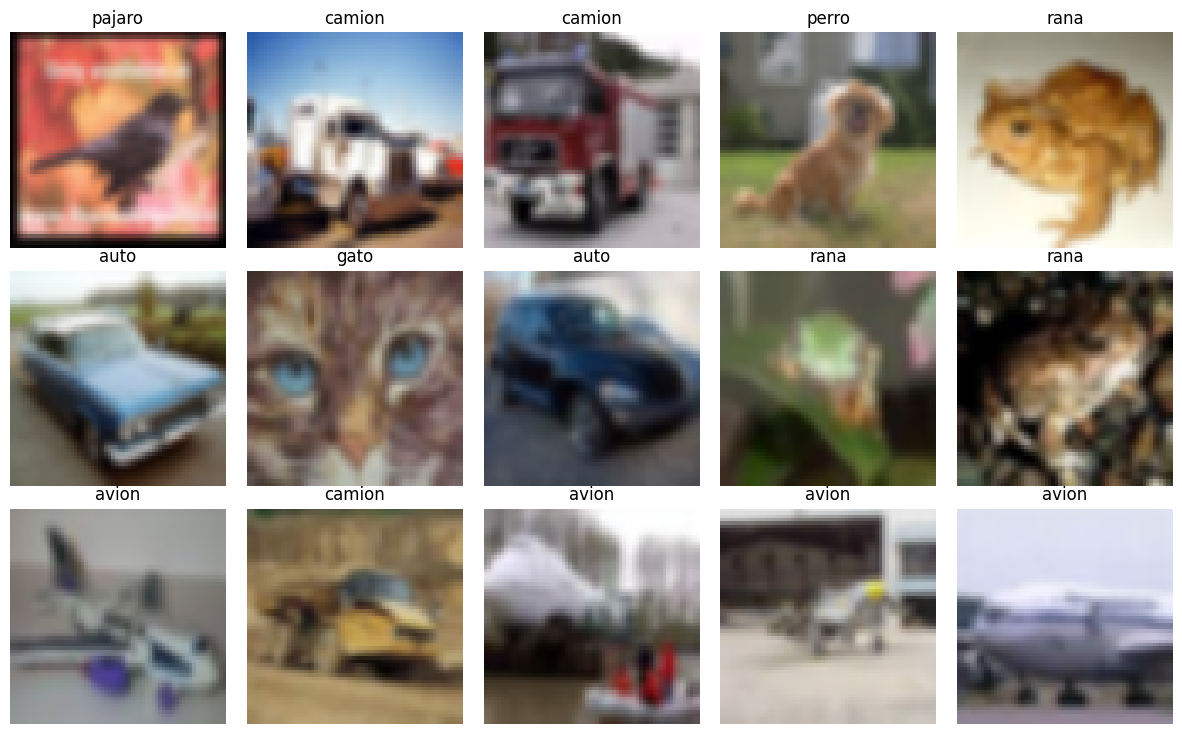

In [11]:
# muestras del dataset
def show_samples():
    r, c = 3, 5
    plt.figure(figsize=(c*3, r*3))
    for row in range(r):
        for col in range(c):
            index = c * row + col
            plt.subplot(r, c, index + 1)
            ix = np.random.randint(0, len(trainset))
            img, label = trainset[ix]
            # desnormalizar la iamgen
            img = img * 0.5 + 0.5
            plt.imshow(np.transpose(img, (1, 2, 0)))
            plt.axis('off')
            plt.title(classes[label])
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

show_samples()

In [12]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, channels=3, features_g=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.main = nn.Sequential(

            nn.ConvTranspose2d(z_dim, features_g * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g * 16),
            nn.LeakyReLU(0.2, inplace=True),

            #1 4x4 -> 8x8
             nn.ConvTranspose2d(features_g * 16, features_g * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 8),
            nn.LeakyReLU(0.2, inplace=True),

            #2 8x8 -> 16x16
             nn.ConvTranspose2d(features_g * 8, features_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 4),
            nn.LeakyReLU(0.2, inplace=True),

            #3 16x16 -> 32x32
            nn.ConvTranspose2d(features_g * 4, features_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 2),
            nn.LeakyReLU(0.2, inplace=True),

            #4 32x32 -> 64x64
            nn.ConvTranspose2d(features_g * 2, features_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g),
            nn.LeakyReLU(0.2, inplace=True),

            # capa de salida
            nn.ConvTranspose2d(features_g, channels, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(-1, self.z_dim, 1, 1)
        return self.main(x)

In [13]:
class Discriminator(nn.Module):
    def __init__(self, channels=3, features_d=32):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(channels, features_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),

            nn.Conv2d(features_d, features_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),

            nn.Conv2d(features_d * 2, features_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),

            nn.Conv2d(features_d * 4, features_d * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(features_d * 8 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [14]:
# inicializacion de pesos
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [15]:
# inicializacion de modelos
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# aplicar inicializacoin de pesos
generator.apply(weights_init)
discriminator.apply(weights_init)

#print(f"Generator parametros: {sum(p.numel() for p in generator.parameters()):,}")
#print(f"Disciminator paramteros: {sum(p.numel() for p in discriminator.parameters()):,}")

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=4096, out_features=1, bias=Tru

epoch 0/10
G_loss: 0.5992, D_loss: 0.7239
D_real_acc: 0.9978, D_fake_acc: 0.0000
balance adecuado


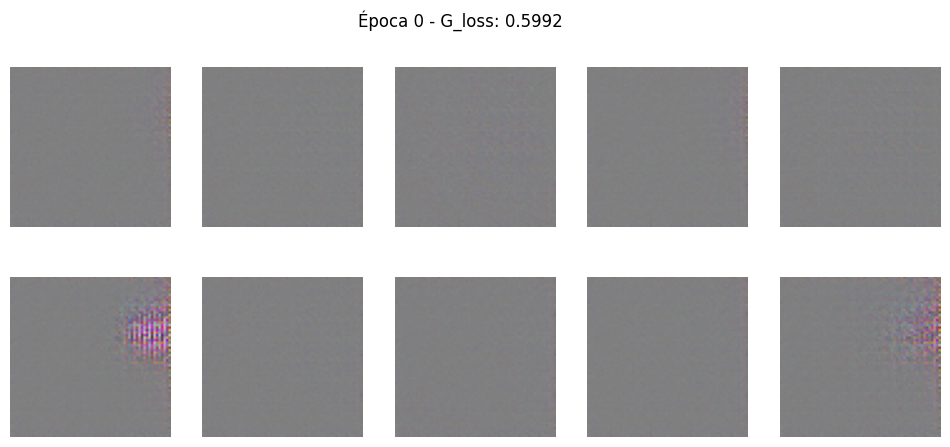

epoch 1/10
G_loss: 0.6826, D_loss: 0.6965
D_real_acc: 0.4910, D_fake_acc: 0.0000
balance adecuado
epoch 2/10
G_loss: 0.6902, D_loss: 0.6941
D_real_acc: 0.0003, D_fake_acc: 0.0000
balance adecuado
epoch 3/10
G_loss: 0.6921, D_loss: 0.6935
D_real_acc: 0.0000, D_fake_acc: 0.0000
balance adecuado
epoch 4/10
G_loss: 0.6926, D_loss: 0.6933
D_real_acc: 0.0000, D_fake_acc: 0.0000
balance adecuado
epoch 5/10
G_loss: 0.6930, D_loss: 0.6932
D_real_acc: 0.0000, D_fake_acc: 0.0000
balance adecuado


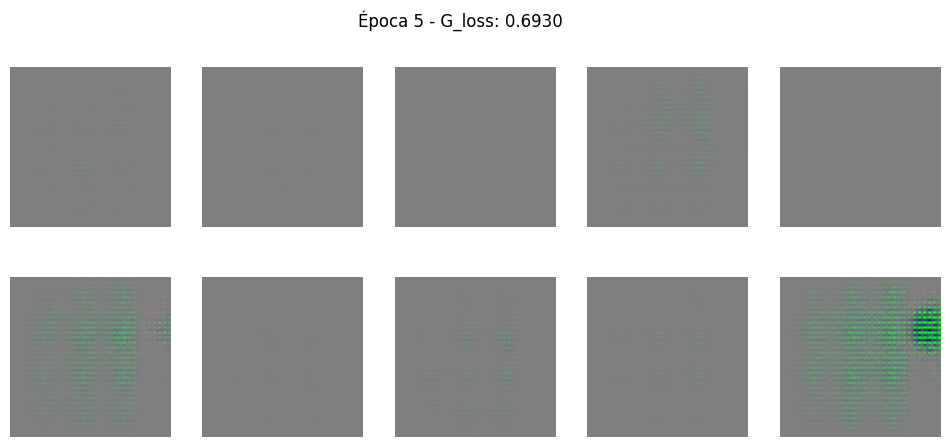

epoch 6/10
G_loss: 0.6931, D_loss: 0.6931
D_real_acc: 0.0000, D_fake_acc: 0.0000
balance adecuado
epoch 7/10
G_loss: 0.6931, D_loss: 0.6931
D_real_acc: 0.0000, D_fake_acc: 0.0000
balance adecuado
epoch 8/10
G_loss: 0.6931, D_loss: 0.6931
D_real_acc: 0.0000, D_fake_acc: 0.0000
balance adecuado
epoch 9/10
G_loss: 0.6931, D_loss: 0.6931
D_real_acc: 0.0000, D_fake_acc: 0.0000
balance adecuado


In [16]:
# funcion fit
def fit(g, d, dataloader, epochs=50):
    g_optimizer = torch.optim.Adam(g.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(d.parameters(), lr=0.00002, betas=(0.5, 0.999))

    criterion = nn.BCEWithLogitsLoss() # para establidad numerica

    hist = {'g_loss': [], 'd_loss': [], 'd_real_acc': [], 'd_fake_acc': []}
    fixed_noise = torch.randn(10, 100, device=device)

    for epoch in range(epochs):
        g_loss_epoch = []
        d_loss_epoch = []
        d_real_acc_epoch = []
        d_fake_acc_epoch = []

        for i, (X, _) in enumerate(dataloader):
            batch_size = X.size(0)

            # entrenamiento del discriminador
            if i % 2 == 0:
                d.zero_grad()

                # imagenes reales
                real_images = X.to(device)
                real_output = d(real_images)
                d_loss_real = criterion(real_output, torch.ones(batch_size, 1, device=device) * 0.8) # label smoothing

                # imagenes falsas
                noise = torch.randn(batch_size, 100, device=device)
                fake_images = g(noise)
                fake_output = d(fake_images.detach())
                d_loss_fake = criterion(fake_output, torch.zeros(batch_size, 1, device=device) + 0.2) #

                d_loss = (d_loss_real + d_loss_fake) / 2
                d_loss.backward()
                d_optimizer.step()
            else:
                d_loss = torch.tensor(0.0)

            # entrenamiento del generador
            g.zero_grad()

            noise = torch.randn(batch_size, 100, device=device)
            fake_images = g(noise)
            fake_output = d(fake_images)
            g_loss = criterion(fake_output, torch.ones(batch_size, 1, device=device))

            g_loss.backward()
            g_optimizer.step()

            # metricas
            with torch.no_grad():
                d_real_acc = (torch.sigmoid(real_output) > 0.5).float().mean()
                d_fake_acc = (torch.sigmoid(fake_output) < 0.5).float().mean()

            d_loss_epoch.append(d_loss.item() if i % 2 == 0 else 0.0)
            g_loss_epoch.append(g_loss.item())
            d_real_acc_epoch.append(d_real_acc.item())
            d_fake_acc_epoch.append(d_fake_acc.item())

        # promedio por epoca
        avg_g_loss = np.mean(g_loss_epoch)
        avg_d_loss = np.mean([x for x in d_loss_epoch if x != 0.0])
        avg_d_real_acc = np.mean(d_real_acc_epoch)
        avg_d_fake_acc = np.mean(d_fake_acc_epoch)

        hist['g_loss'].append(avg_g_loss)
        hist['d_loss'].append(avg_d_loss)
        hist['d_real_acc'].append(avg_d_real_acc)
        hist['d_fake_acc'].append(avg_d_fake_acc)

        print(f'epoch {epoch}/{epochs}')
        print(f'G_loss: {avg_g_loss:.4f}, D_loss: {avg_d_loss:.4f}')
        print(f'D_real_acc: {avg_d_real_acc:.4f}, D_fake_acc: {avg_d_fake_acc:.4f}')

        # Feedback específico
        if avg_d_fake_acc > 0.8:
            print("discriminador demasiado fuerte, ajustando...")
        elif avg_d_fake_acc < 0.6:
            print("balance adecuado")
        else:
            print("balance moderado")

        if epoch % 5 == 0:
            with torch.no_grad():
                g.eval()
                fake_images = g(fixed_noise).cpu()
                fig, axes = plt.subplots(2, 5, figsize=(12, 5))
                for i, ax in enumerate(axes.flat):
                    img = fake_images[i] * 0.5 + 0.5
                    ax.imshow(np.transpose(img, (1, 2, 0)))
                    ax.axis('off')
                plt.suptitle(f'Época {epoch} - G_loss: {avg_g_loss:.4f}')
                plt.show()
                g.train()

    return hist

hist = fit(generator, discriminator, dataloader, epochs=10)

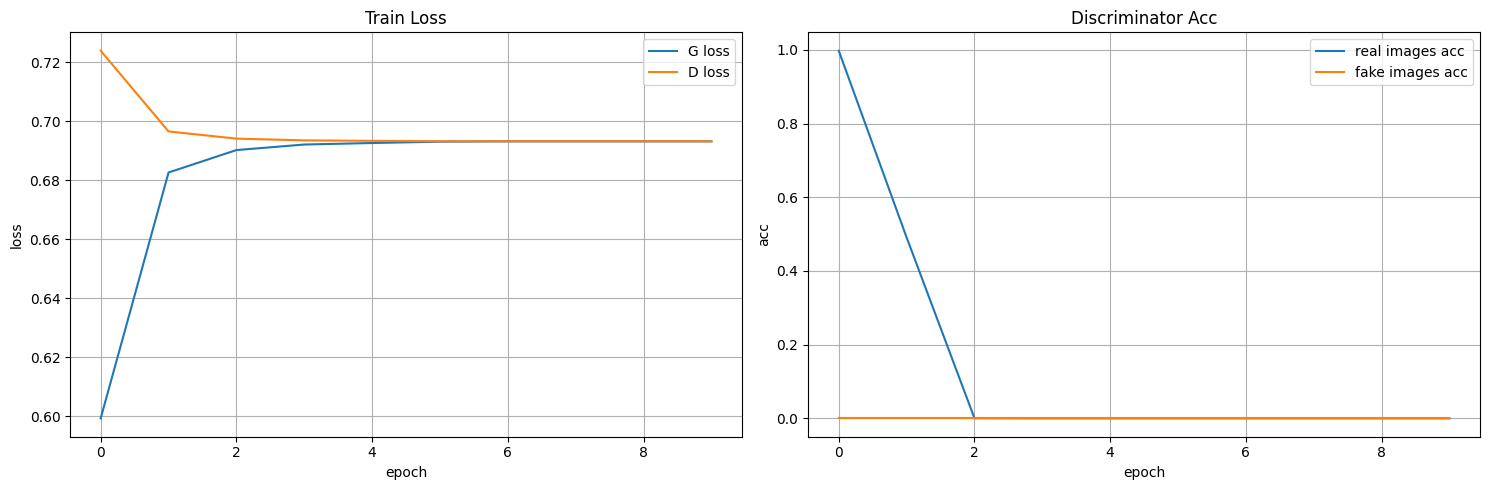

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hist['g_loss'], label='G loss')
plt.plot(hist['d_loss'], label='D loss')
plt.title('Train Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist['d_real_acc'], label='real images acc')
plt.plot(hist['d_fake_acc'], label='fake images acc')
plt.title('Discriminator Acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


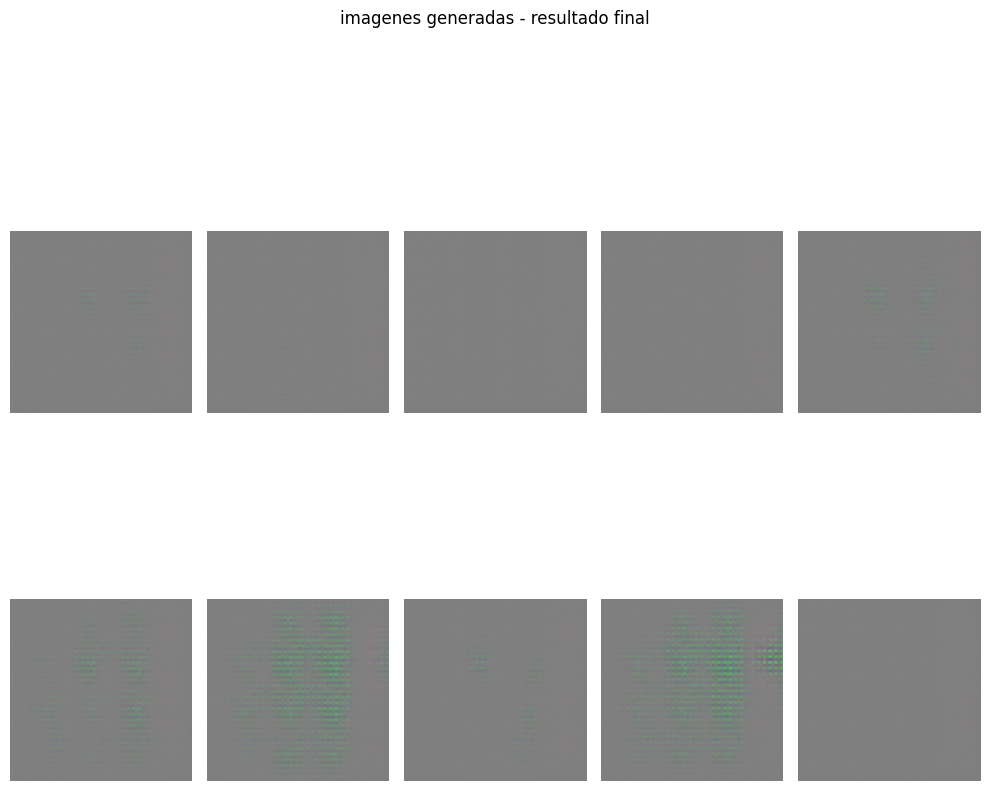

In [18]:
# generacion de imagenes
def generate_images():
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(10, 100, device=device)
        generated_images = generator(noise).cpu()

        fig, axes = plt.subplots(2, 5, figsize=(10, 10))
        for i, ax in enumerate(axes.flat):
            img = generated_images[i] * 0.5 + 0.5  # desnormalizar
            ax.imshow(np.transpose(img, (1, 2, 0)))
            ax.axis('off')
        plt.suptitle('imagenes generadas - resultado final')
        plt.tight_layout()
        plt.show()

generate_images()

In [19]:
# evaluacion final
print(f"G_final_loss: {hist['g_loss'][-1]:.4f}")
print(f"D_final_loss: {hist['d_loss'][-1]:.4f}")
print(f"D_real_acc: {hist['d_real_acc'][-1]:.4f}")
print(f"D_fake_acc: {hist['d_fake_acc'][-1]:.4f}")
# guardar modelos
torch.save(generator.state_dict(), 'dcgan_generator_nfnet.pth')
torch.save(discriminator.state_dict(), 'dcgan_discriminator_nfnet.pth')

G_final_loss: 0.6931
D_final_loss: 0.6931
D_real_acc: 0.0000
D_fake_acc: 0.0000
